# 0.0. PASSO 00 - IMPORTS

In [7]:
#import PANDAS 

import math
import datetime
import matplotlib
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt


from scipy                 import stats

from boruta                import BorutaPy

from tabulate              import tabulate

from IPython.display       import Image 
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


### 0.1. Helper Functions

In [8]:
def cross_validation( x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold number: {}'.format(k) )
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)  ]


        #training and validation dataset

        #training 
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']


        #model
        m = model.fit(xtraining, ytraining )

        #prediction
        yhat = m.predict(xvalidation)


        #performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        #store performance of each kfold interation
        mae_list.append(  m_result['MAE']  )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame ( {'Model Name': model_name,
                           'MAE CV': np.round(np.mean( mae_list ), 2).astype( str ) + ' +/- ' +  np.round(np.std( mae_list ), 2).astype( str ),
                           'MAPE CV': np.round(np.mean( mape_list ), 2).astype( str ) + ' +/- ' +  np.round(np.std( mape_list ), 2).astype( str ),
                           'RMSE CV': np.round(np.mean( rmse_list ), 2).astype( str ) + ' +/- ' +  np.round(np.std( rmse_list ), 2).astype( str ) }, index=[0] )

def mean_percentage_error ( y, yhat):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error ( y, yhat):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error (model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame ( { 'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse}, index=[0] )


def jupyter_settings():
     %matplotlib inline
     %pylab inline
     plt.style.use( 'bmh' )
     plt.rcParams['figure.figsize'] = [25, 12]
     plt.rcParams['font.size'] = 24
     display( HTML( '<style>.container { width:100% !important; }</style>') )
     pd.options.display.max_columns = None
     pd.options.display.max_rows = None
     pd.set_option( 'display.expand_frame_repr', False )
     sns.set()


In [9]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 0.2. Load Datasets

In [10]:
#read dataset 
df_sales_raw = pd.read_csv('../datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../datasets/store.csv', low_memory=False)


#merge df's

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on="Store")

# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [11]:
#Show the sample of the data
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
325415,256,6,2014-09-27,10124,1370,1,0,0,0,a,c,80.0,9.0,2005.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"



# 1.0. DATA DESCRITPTION

In [12]:
#Copy the original data
df1 = df_raw.copy()

## 1.1. Rename Columns

In [13]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']


#Function Snake Case
snackecase = lambda x: inflection.underscore(x)

#Map of the names
cols_new = list(map(snackecase, cols_old))

#Rename name columns
df1.columns = cols_new

## 1.2 Data Dimensions

In [14]:
print('Number of the rows: {}'.format(df1.shape[0]))
print('Number of the Cols: {}'.format(df1.shape[1]))

Number of the rows: 1017209
Number of the Cols: 18


## 1.3 Data Types

In [15]:
#Change the type for DATETIME the column DATE
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [16]:
#Check SUM of the NA
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [17]:
#competition_distance              2642
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x )

#competition_open_since_month    323348
df1['competition_open_since_month'] =  df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     323348
df1['competition_open_since_year'] =  df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week               508031
df1['promo2_since_week'] =  df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year               508031
df1['promo2_since_year'] =  df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval                  508031
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] =  df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in  x['promo_interval'].split(',') else 0, axis=1)

## 1.6. Change Types

In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [19]:
#Separate the numerics and categorics 

#numerics
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

#categorics
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [20]:
# Central Tendency - mean, median

ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate the dispersions

metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

In [21]:
metrics.columns = [['Attributes','Min', 'Max', 'Range', 'Media', 'Mediana', 'STD', 'Skew', 'Kurtosis']]

In [22]:
metrics

,Attributes,Min,Max,Range,Media,Mediana,STD,Skew,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


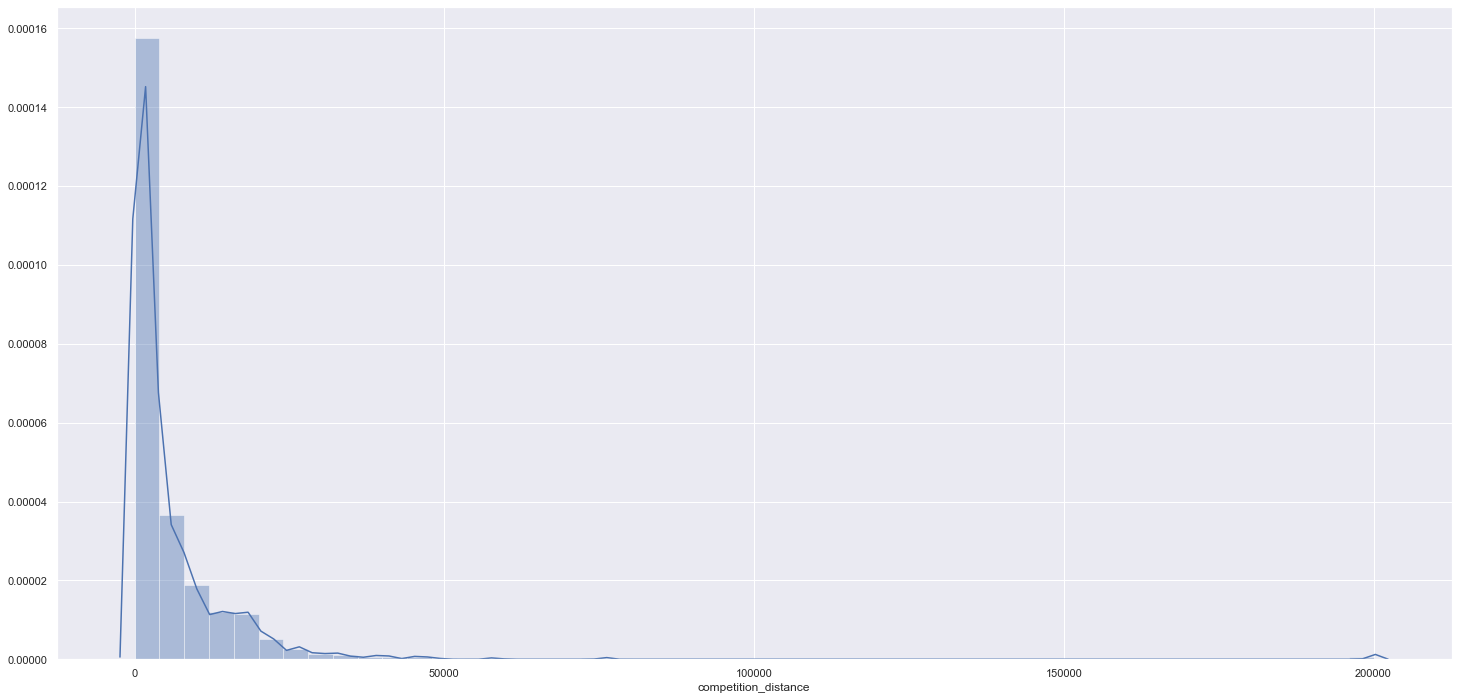

In [23]:
sns.distplot( df1['competition_distance'] )

### 1.7.2 Categorical Attributes

In [24]:
#Types of categorical
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

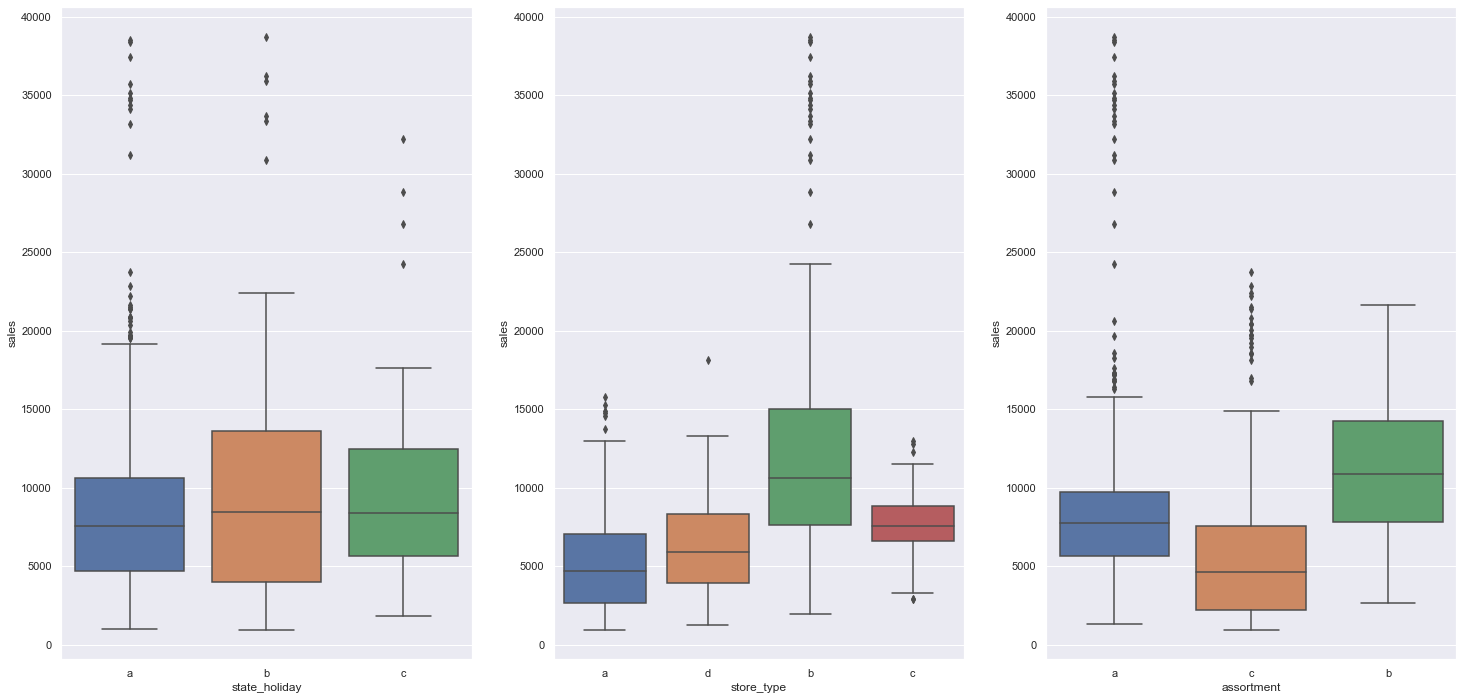

In [25]:
#Create BOX PLOT
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0 )]


plt.subplot( 1, 3 ,1)
sns.boxplot(x='state_holiday' , y='sales', data=aux1)

plt.subplot( 1, 3 ,2)
sns.boxplot(x='store_type' , y='sales', data=aux1)

plt.subplot( 1, 3 ,3)
sns.boxplot(x='assortment' , y='sales', data=aux1)

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [26]:
df2 = df1.copy()

## 2.1. Mind Map Hiphotese

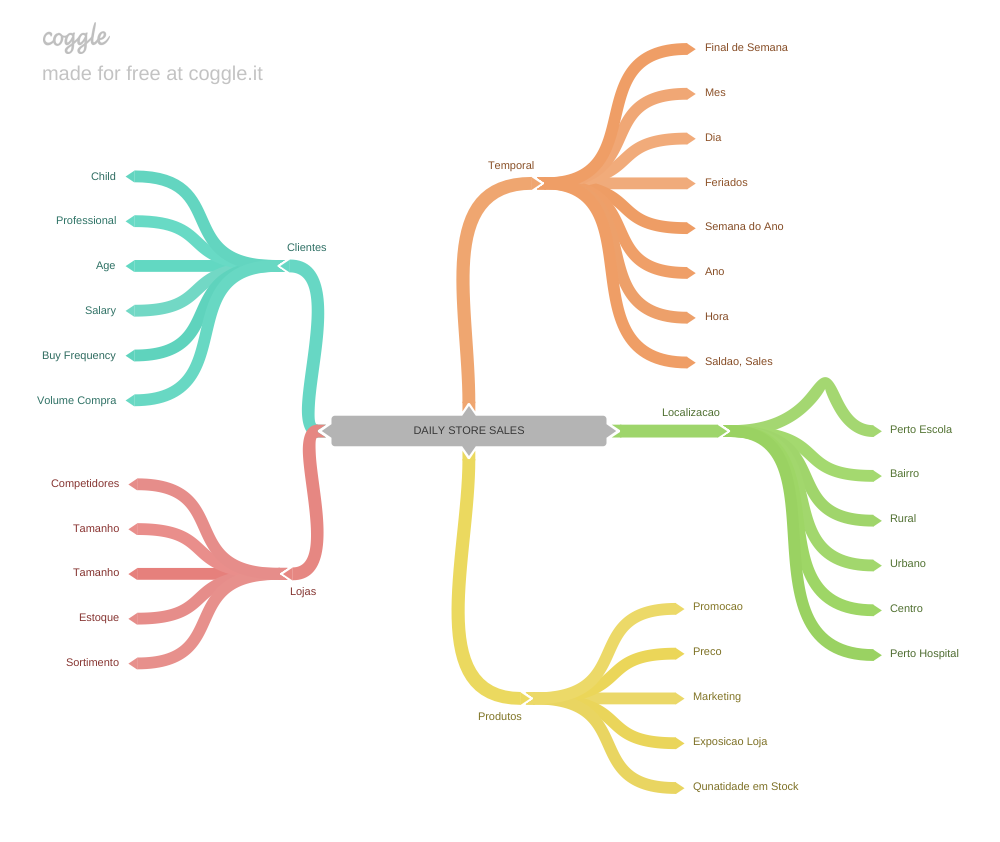

In [27]:
#import image
Image( '../img/MindMapHipothesis.png' )

## 2.2. Create Hiphoteses

### 2.2.1. Store Hiphoteses

**1.** Lojas com maior numero de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.2.2. Products Hiphoteses

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposicao de produtos deveriam vender mais.

**3.** Lojas com produtos com menor preco deveriam vender mais

**4.** Lojas com promocoes mais agressivas (desconto maiores), deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com promocoes consecutivas deveriam vender mais.

### 2.2.3. Temporal Hiphoteses

**1.** Lojas abertas durante o oferiado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de casa mes.

**5.** Lojas deveriam vender menos aos finais de semana.

**5.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Final List - Hiphoteses

### dica01 - Usar as variaveis que ja tem os dados disponiveis.

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas com promocoes consecutivas deveriam vender mais.

**7.** Lojas abertas durante o oferiado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de casa mes.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feaute Engineering

In [28]:
#year
#transform DATE in DATE TIME and put YEAR for colect year
df2['year'] = df2['date'].dt.year
#month
#transform DATE in DATE TIME and put MONTH for colect MONTH
df2['month'] = df2['date'].dt.month
#day
#transform DATE in DATE TIME and put DAY for colect DAY
df2['day'] = df2['date'].dt.day

#week of year
#transform DATE in DATE TIME and put WEEK OF YEAR for colect WEEK OF YEAR
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
#transform DATE in DATE TIME + STRFTIME for change the DATE
df2['year_of_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since
#merge competition_open_since_month + competition_open_since_year
#put DAY = 1 for every store because not have the day in the DATE.

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days  ).astype(int)

#promo since
#Convert to STR
df2['promo_since'] =  df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7 ))

df2['promo_time_week'] =  ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype( int )

#assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regulary_day')


# 3.0. PASSO 03 - FILTRAGEM DE VARIAVEIS

In [29]:
df3 = df2.copy()

In [30]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_of_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regulary_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regulary_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regulary_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regulary_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regulary_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [31]:
#Open = 0 - fechada
#Sales maior que 0
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [32]:
#restricoes
#Depois de filtrar eu retiro a open porque vai sobrar so o que eu nao quero.
cols_drop = ['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [33]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_of_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regulary_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regulary_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regulary_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regulary_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regulary_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0. PASSO 04 -  ANALISE EXPLORATORIA DE DADOS


In [34]:
df4 = df3.copy()

## 4.1. Analise Univariada


### 4.1.1.  Response Variable


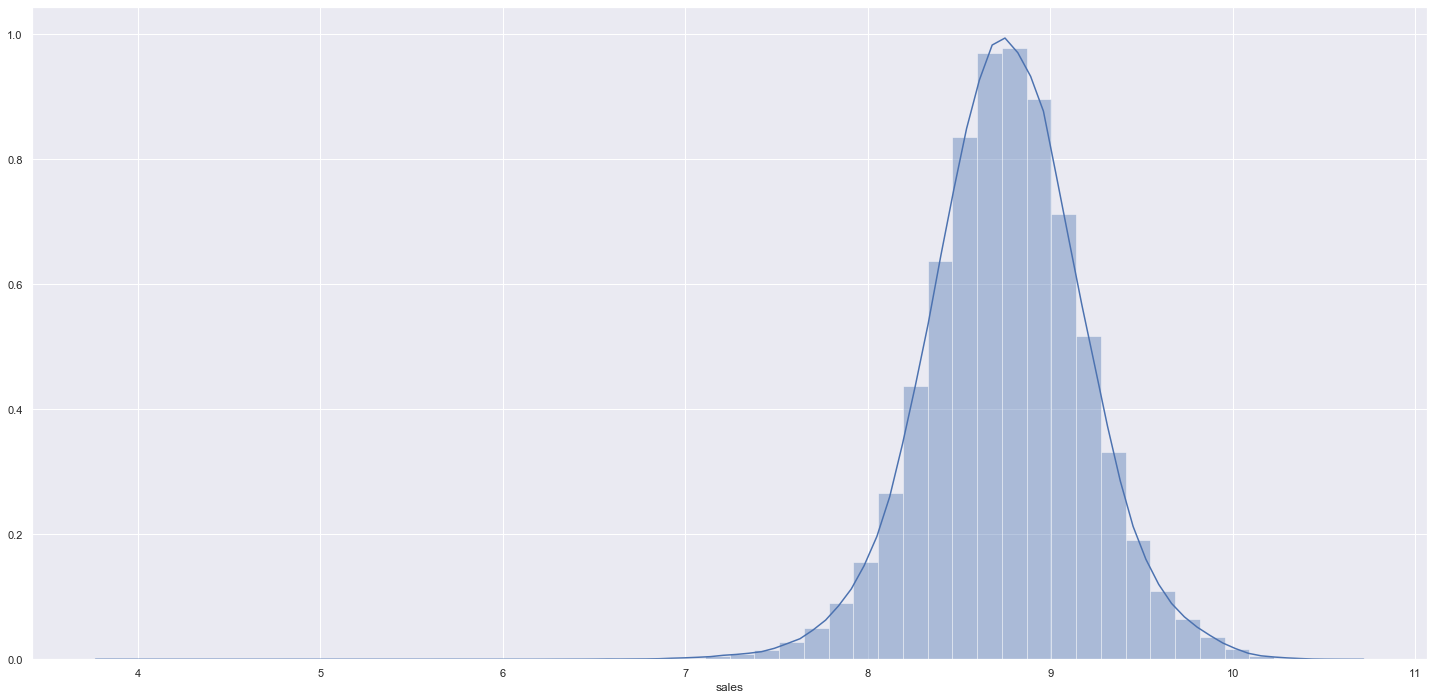

In [35]:
#Plotagem da distribuicao
#Lembrar da Kurtose
#Tem que ficar como uma NORMAL, CENTRADA.
#sns.distplot(df4['sales'])


#transformacao usando LOG para deixar mais perto de uma NORMAL
sns.distplot(np.log1p(df4['sales']))

### 4.1.2.  Numerical Variable


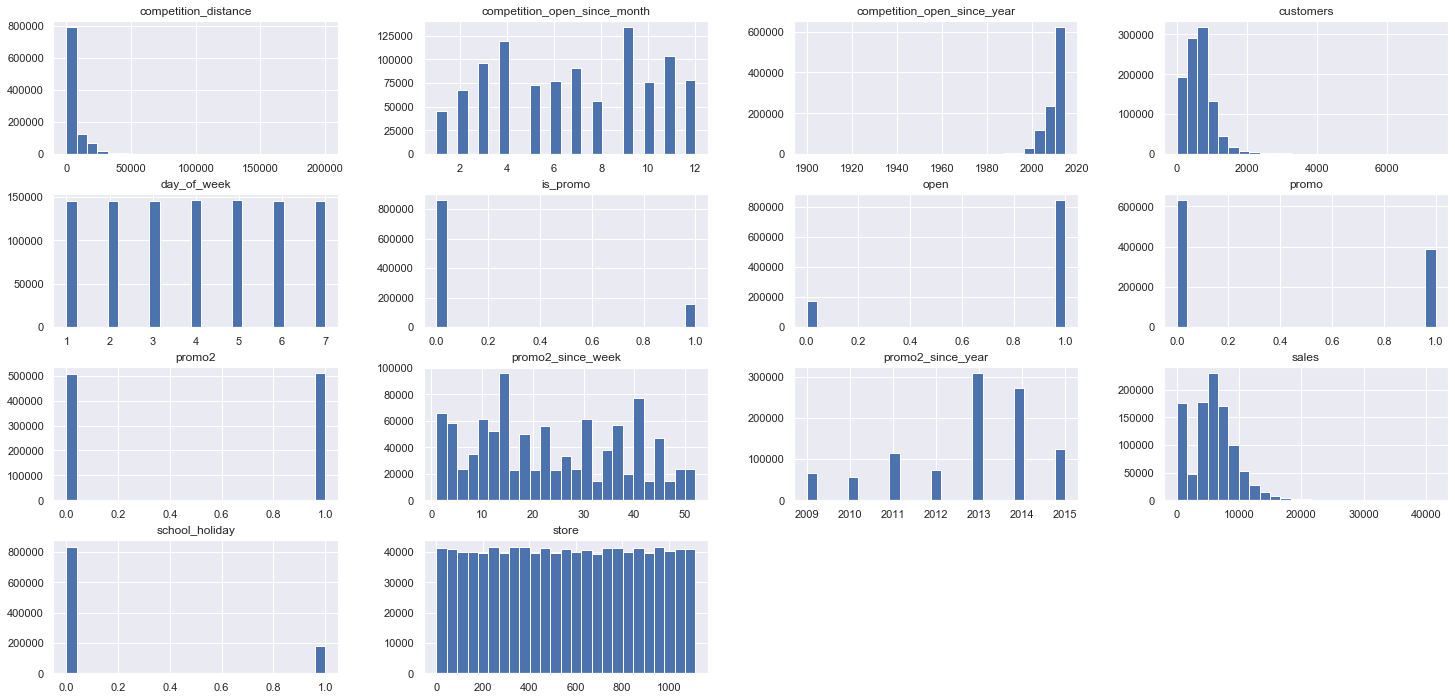

In [36]:
num_attributes.hist(bins=25);

### 4.1.3.  Categorical Variable


In [37]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [38]:
#keep just the original kinds
df4['state_holiday'].drop_duplicates()

0           regulary_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [39]:
#keep just the original kinds
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

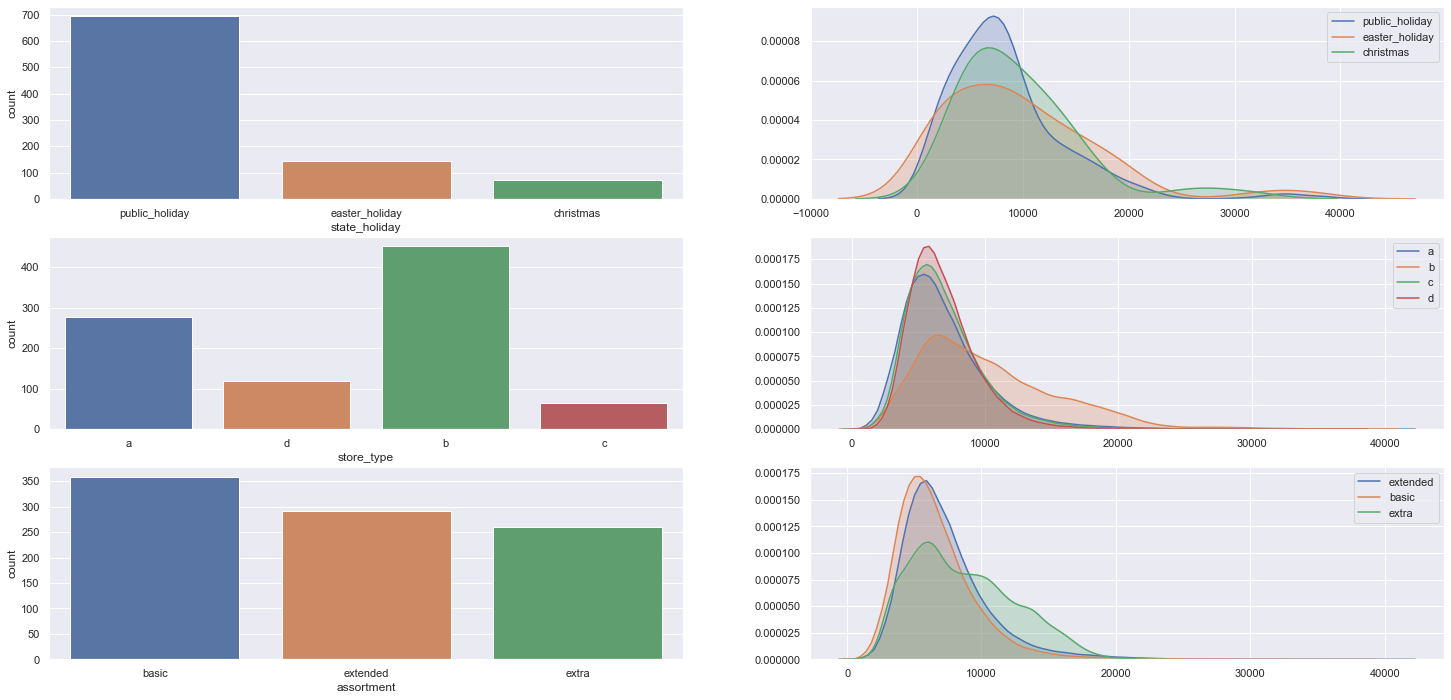

In [40]:
#Dividindo em 2 linha, 2 colunhas, na 1 coluna
plt.subplot(3,2,1)

#Conta quantas vendas tem em cada holiday
#filtrando os holidays diferente de regulary_date
a = df4[df4['state_holiday'] != 'regulary_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
#Selecionando as VENDAS do public_holiday
#Plotando um grafico KDEPLOT - LABEL - SHADE = transparencia
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)


plt.subplot(3,2,3)

#Conta quantas vendas tem em cada holiday
#filtrando os tipos de loja
sns.countplot(a['store_type'])

plt.subplot(3,2,4)
#Selecionando as VENDAS do public_holiday
#Plotando um grafico KDEPLOT - LABEL - SHADE = transparencia
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#Conta quantas vendas tem em cada holiday
#filtrando os tipos de loja
plt.subplot(3,2,5)
sns.countplot(a['assortment'])

plt.subplot(3,2,6)
#Selecionando as VENDAS do public_holiday
#Plotando um grafico KDEPLOT - LABEL - SHADE = transparencia
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2. Analise Bivariada


### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSE** Lojas com MAIOR SORTIMENTO vendem MENOS.

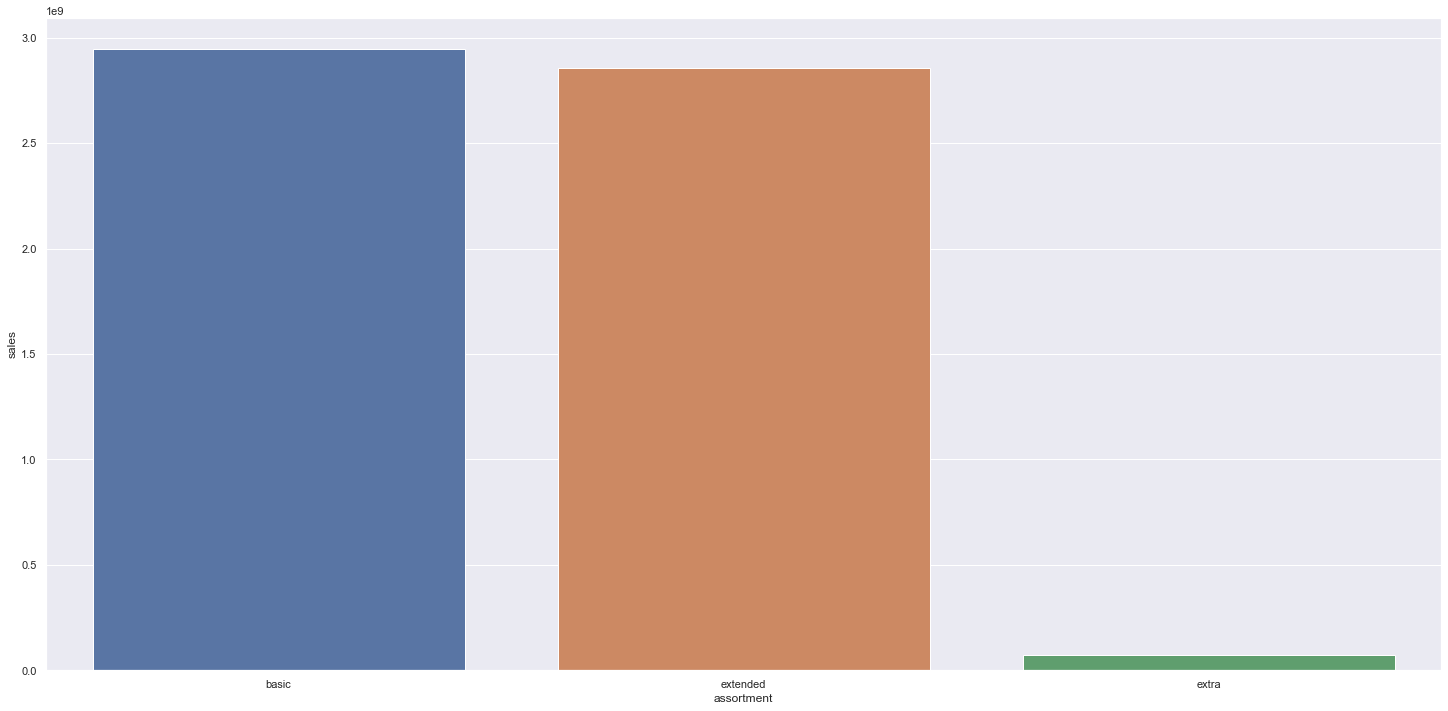

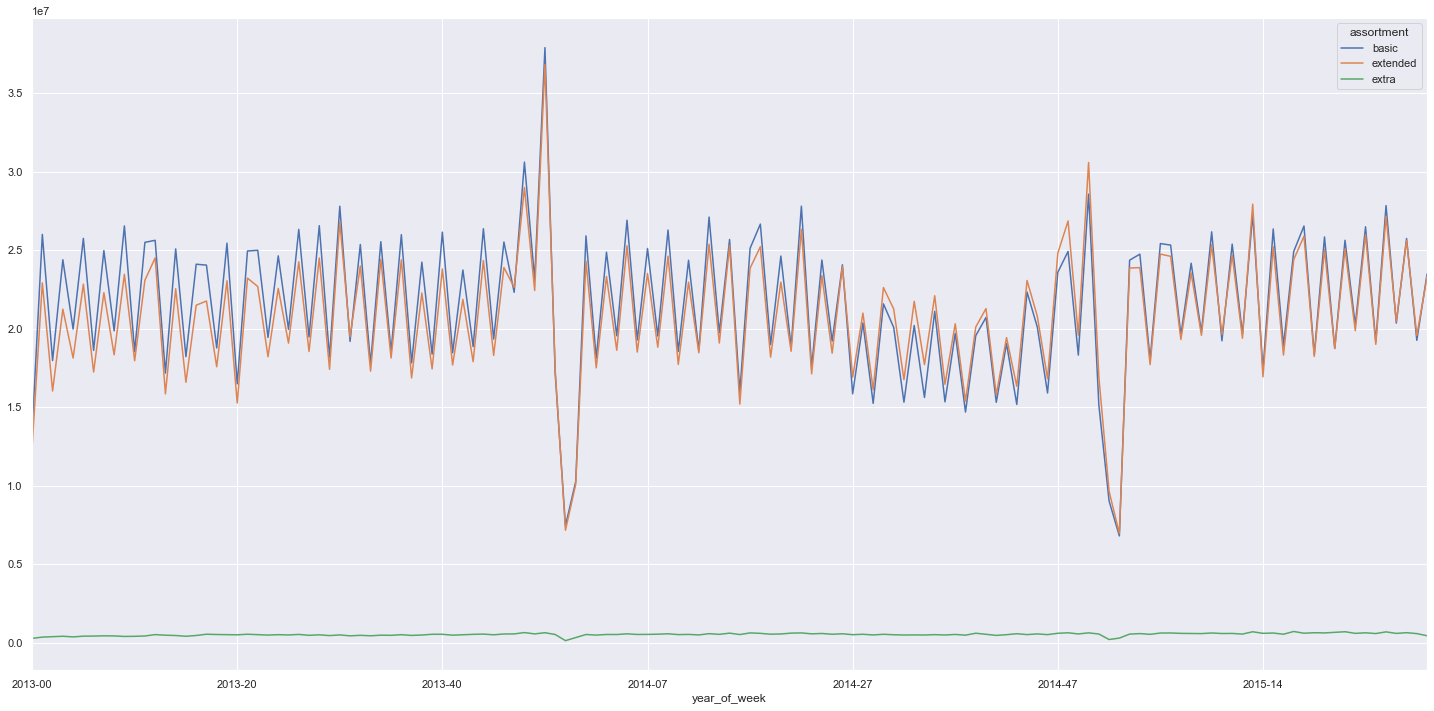

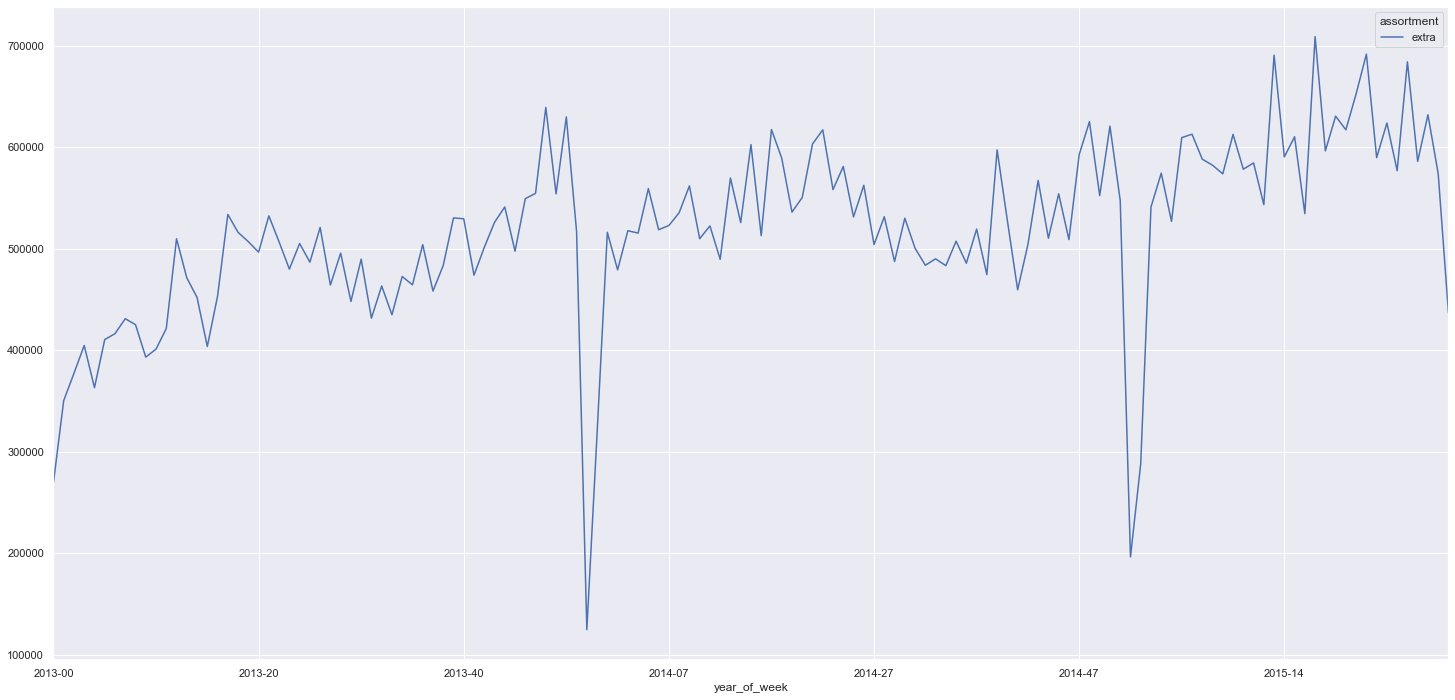

In [41]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1 );

aux2 = df4[['assortment', 'sales','year_of_week']].groupby( ['year_of_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_of_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_of_week', columns='assortment', values='sales' ).plot()

### **H2.** Lojas com competidores mais proximos deveriam vender menos
**FALSE** Lojas com COMPETIDORES MAIS PROXIMOS deveriam vender MAIS

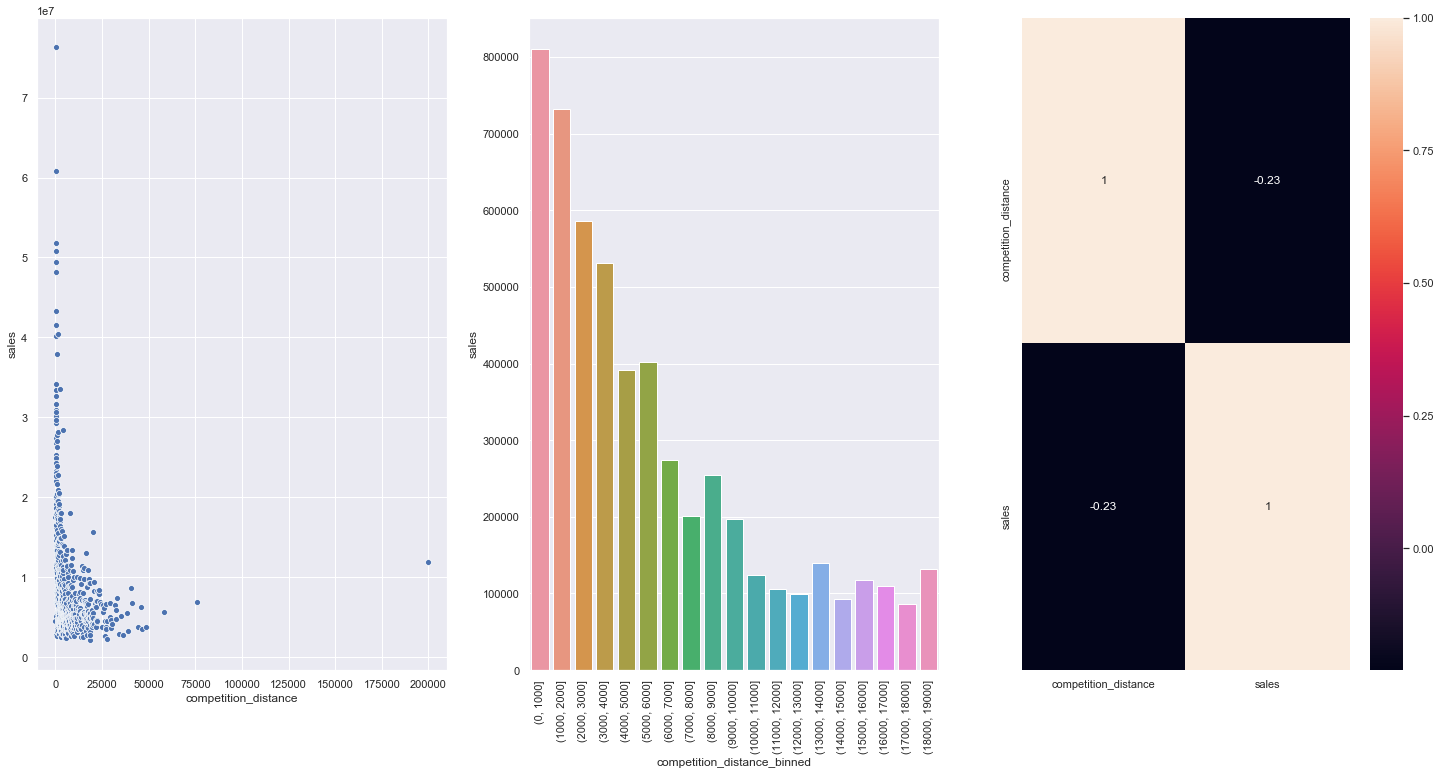

In [42]:
plt.subplot(1, 3, 1)
#TIP: Datas with a lot granulare and have the difficult for analyse it`s good idea put this data in SCATTER PLOT (points).

##Group by COMPETITION DISTANCE
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

sns.scatterplot(x = 'competition_distance', y = 'sales', data=aux1);



plt.subplot(1, 3, 2)
#Group by COMPETITION DISTANCE
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

#Create a LIST with groups/BINS - 0 to 20000 with interval of 1000
bins = list( np.arange( 0, 20000, 1000 ) )

#Create a new column with BINS
#CUT the columns with interval and put in the new column
df4['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins )

#Group by COMPETITION DISTANCE BINNED
aux2 = df4[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
#Plot the BARPLOT
sns.barplot(x='competition_distance_binned', y='sales', data=aux2 );
#Rotation 90 graus the BAR
plt.xticks(rotation=90);


plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H3.** Lojas com competidores a mais tempo deveriam vender mais
**FALSE** Lojas com COMPETIDORES a mais tempo VENDEM MENOS

In [43]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_of_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week',
       'competition_distance_binned'],
      dtype='object')

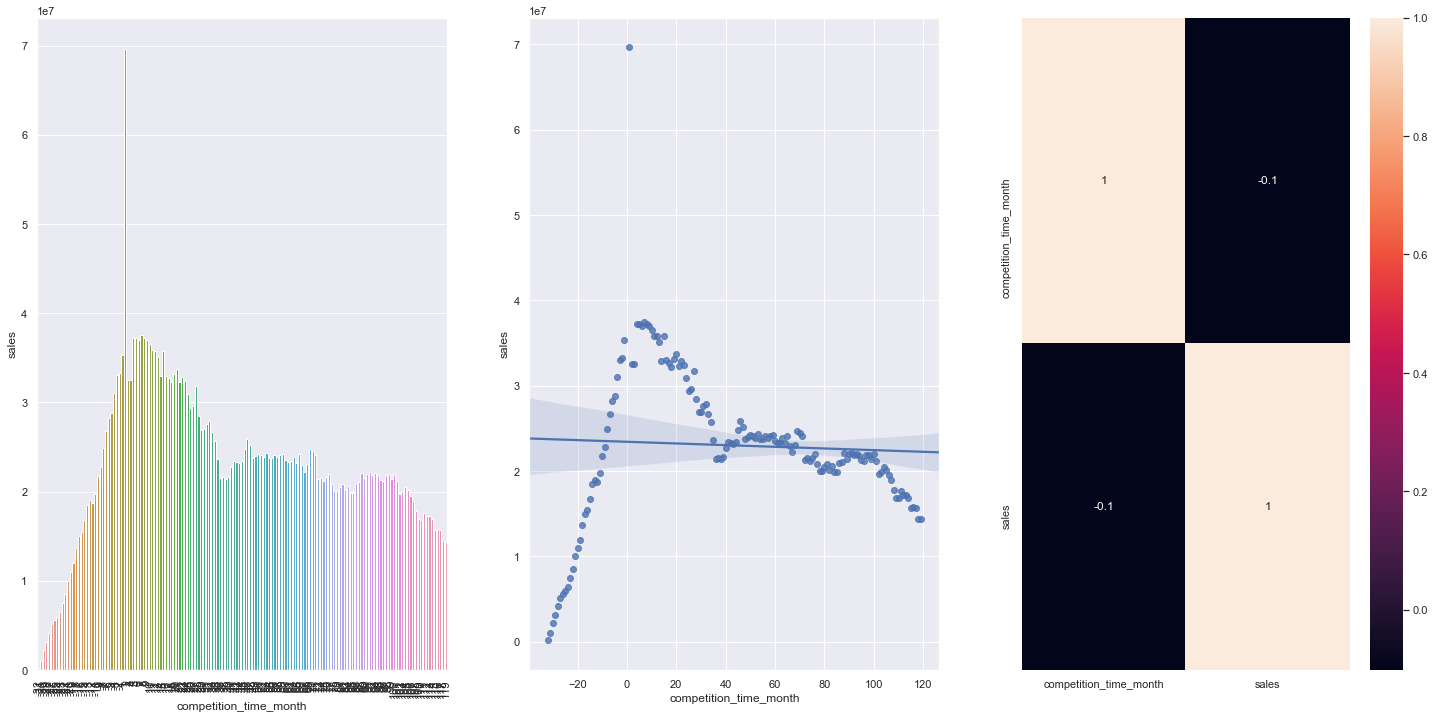

In [44]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2 );
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.
**FALSE** Lojas com PROMOCOES ATIVAS a mais tempo VENDEM MENOS depois de um certo periodo de promocao


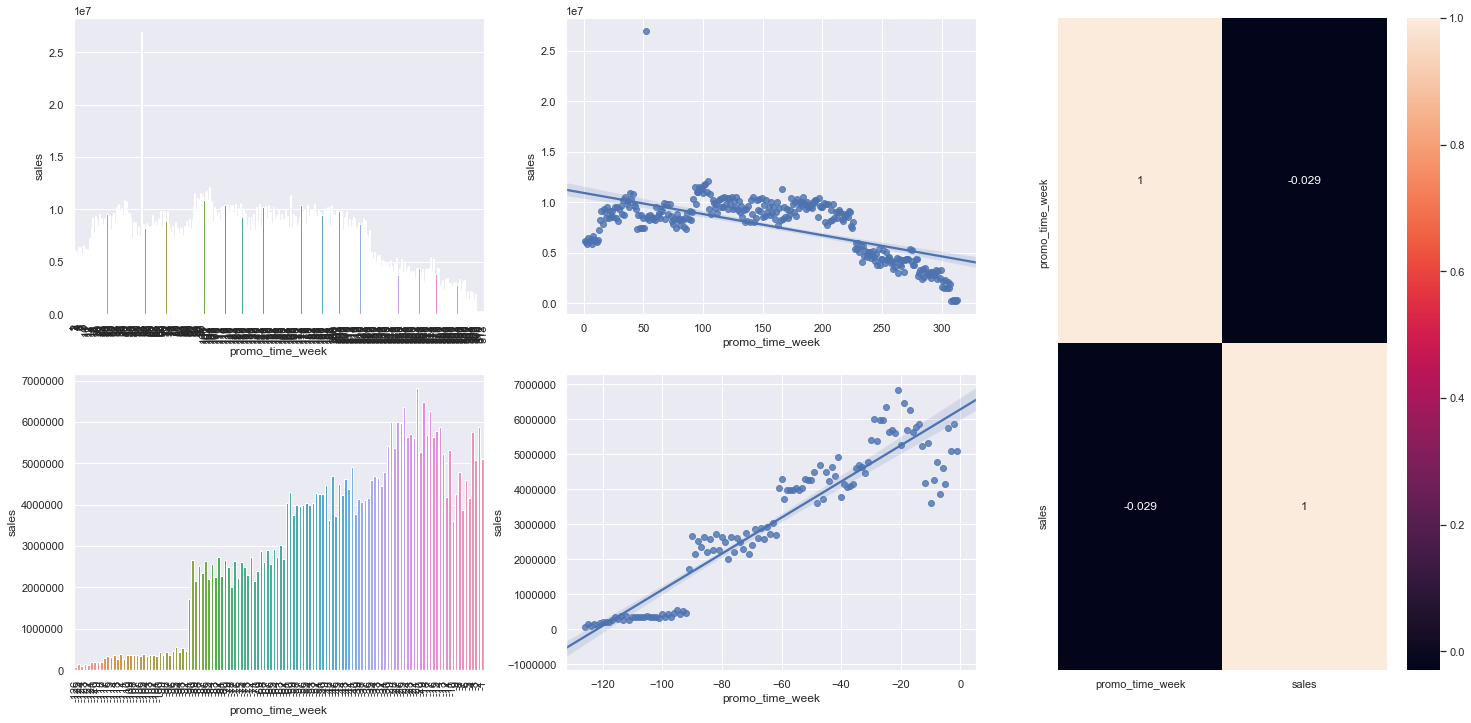

In [45]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week', y='sales', data=aux1);

grid = GridSpec( 2, 3 )

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap (aux1.corr(method='pearson'),annot=True);

### <s>**H5.** Lojas com mais dias de promocao deveriam vender mais.</s>

In [46]:
#next cicle 

### **H6.** Lojas com promocoes consecutivas deveriam vender mais.

In [47]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


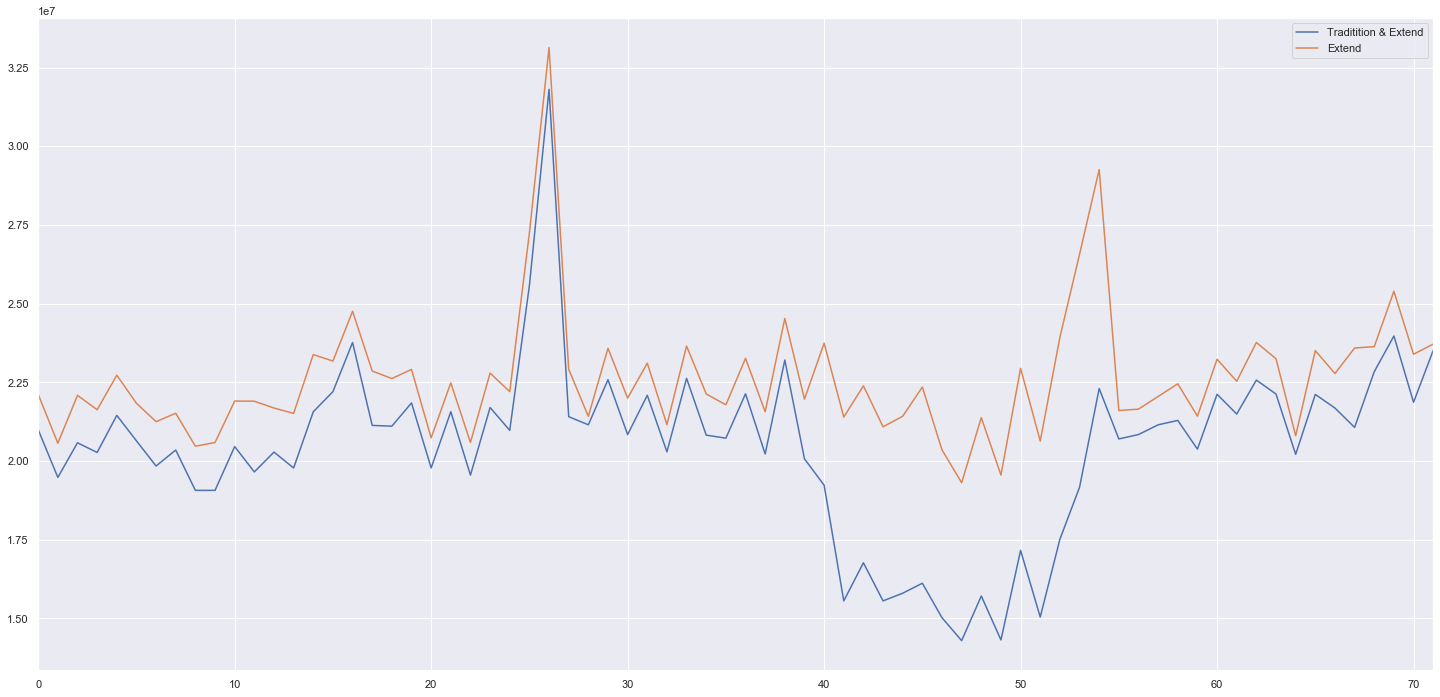

In [48]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1) ][['year_of_week', 'sales']].groupby('year_of_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0) ][['year_of_week', 'sales']].groupby('year_of_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend( labels=['Traditition & Extend', 'Extend'] )

### **H7.** Lojas abertas durante o oferiado de Natal deveriam vender mais.
**FALSE** Lojas abertas durante o oferiado de Natal vendem menos

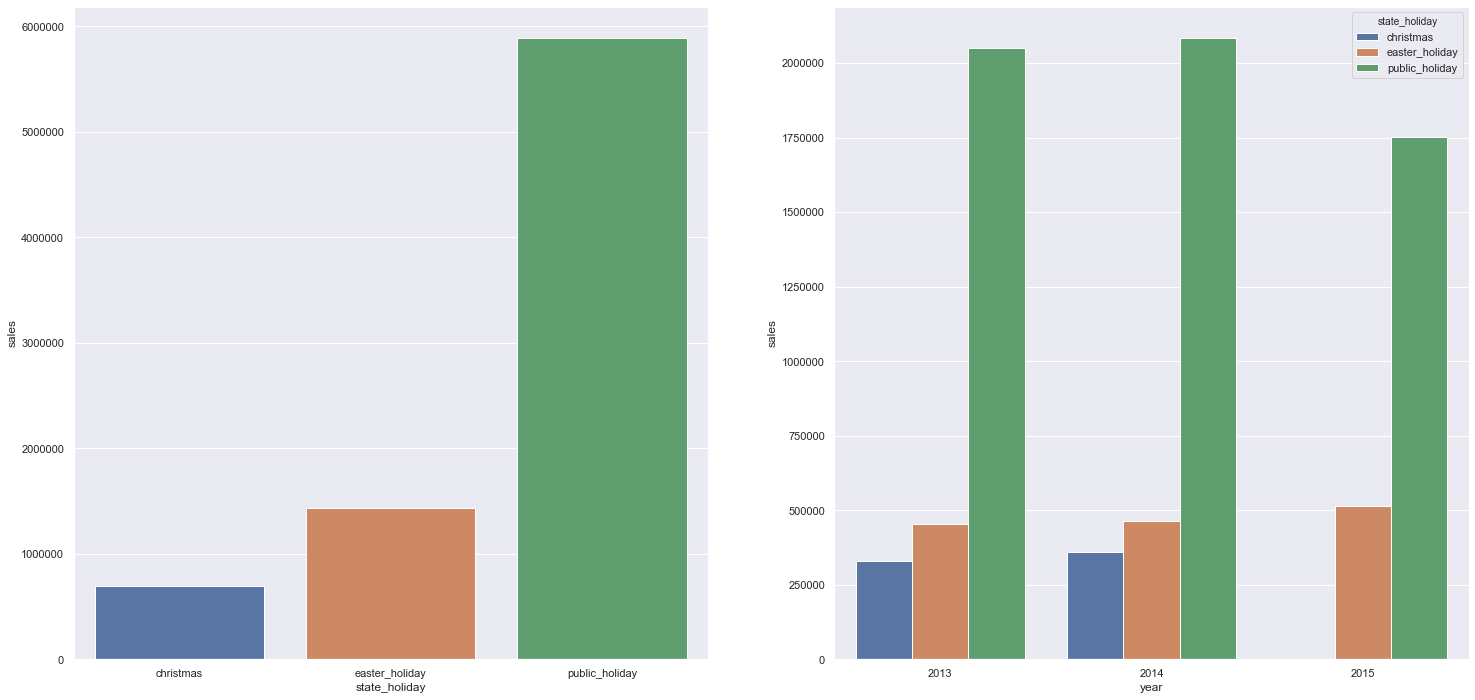

In [49]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regulary_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday',  data=aux2);


### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSE** Lojas vendem menos ao longo dos anos.

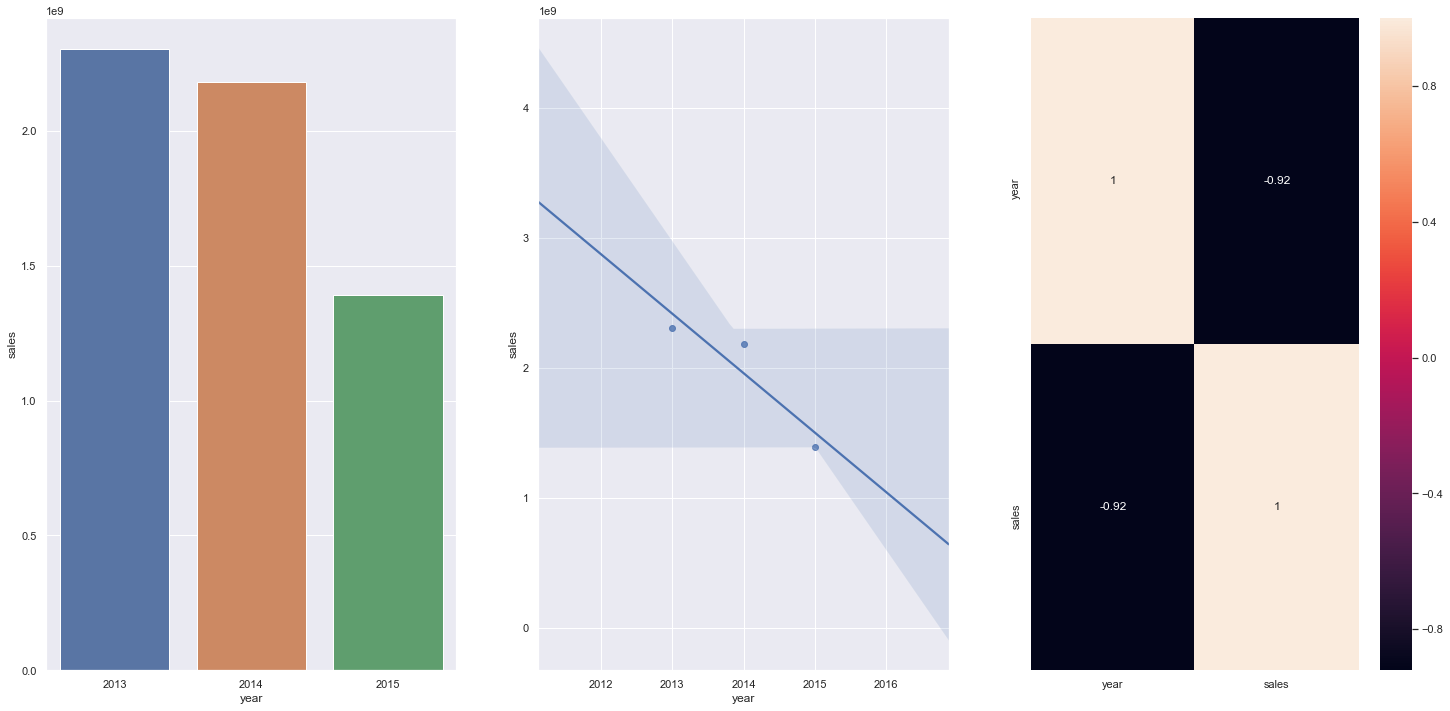

In [50]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
#tendency
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
#result corelation
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSE** Lojas vendem menos no segundo semestre do ano.

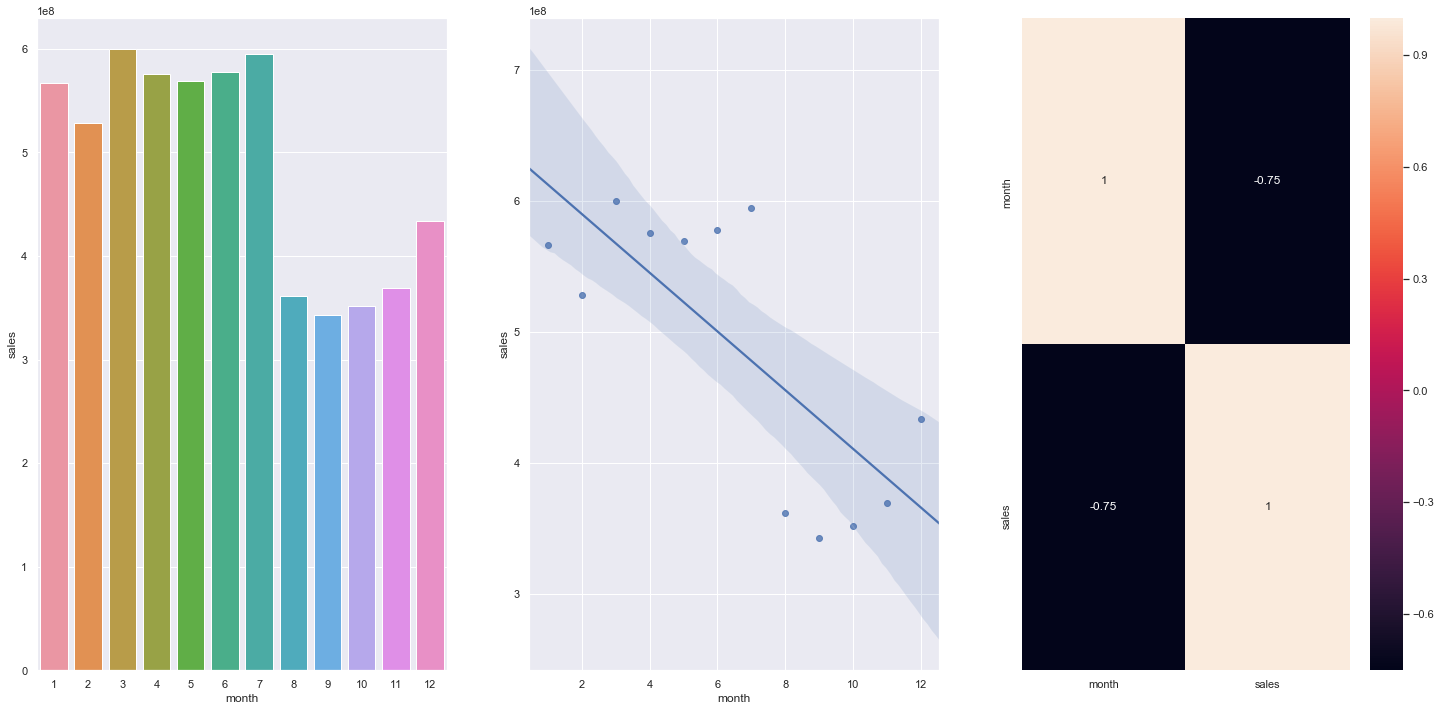

In [51]:
plt.subplot( 1, 3, 1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
#tendency
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 3)
#result corelation
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mes.
**TURE** Lojas vendem mais depois do dia 10 de cada mes.

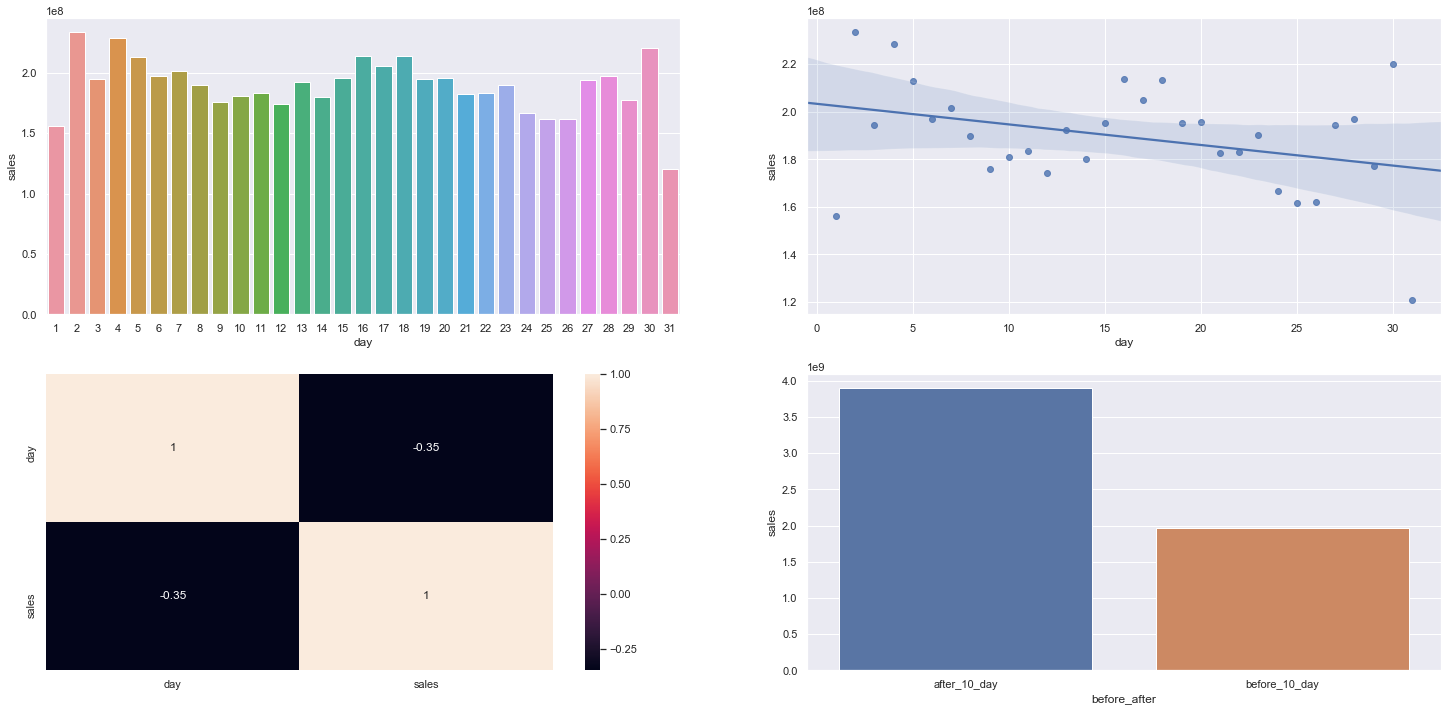

In [52]:
plt.subplot( 2, 2, 1 )
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1 );

#tendency
plt.subplot( 2, 2, 2 )
sns.regplot(x='day', y='sales', data=aux1 );

#result corelation
plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr(method='pearson'), annot=True  );

plt.subplot( 2, 2, 4 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_day' if x <= 10 else 'after_10_day' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

sns.barplot(x='before_after', y='sales', data=aux2 );



### **H11.** Lojas deveriam vender menos aos finais de semana.
**TRUE** Lojas vendem menos aos finais de semana

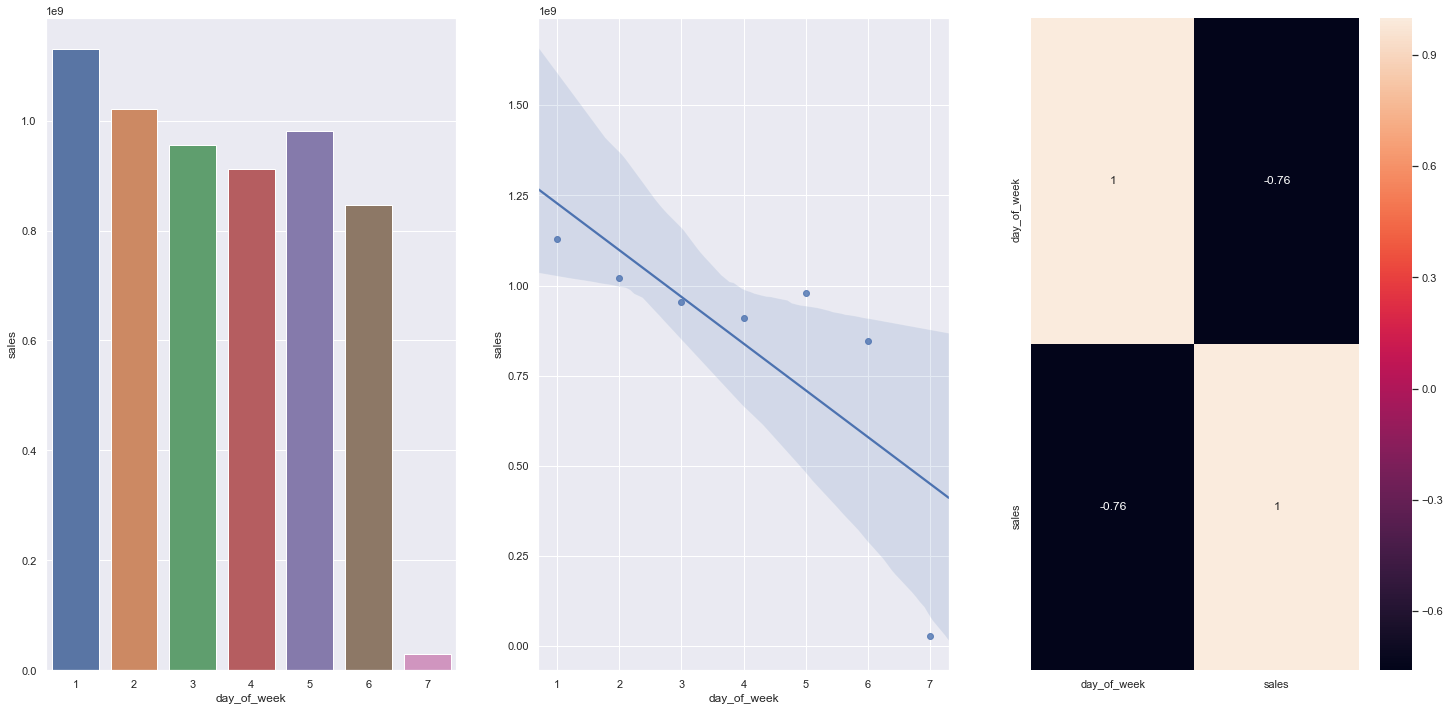

In [53]:
plt.subplot( 1, 3, 1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
#tendency
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 3)
#result corelation
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**TRUE** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto

## 4.2.1 Resumo das Hipoteses

In [54]:
tab = [[' Hipotese', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]
print (tabulate(tab, headers='firstrow'))

 Hipotese    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Analise Multivariada


### 4.3.1 Numerical Attributes

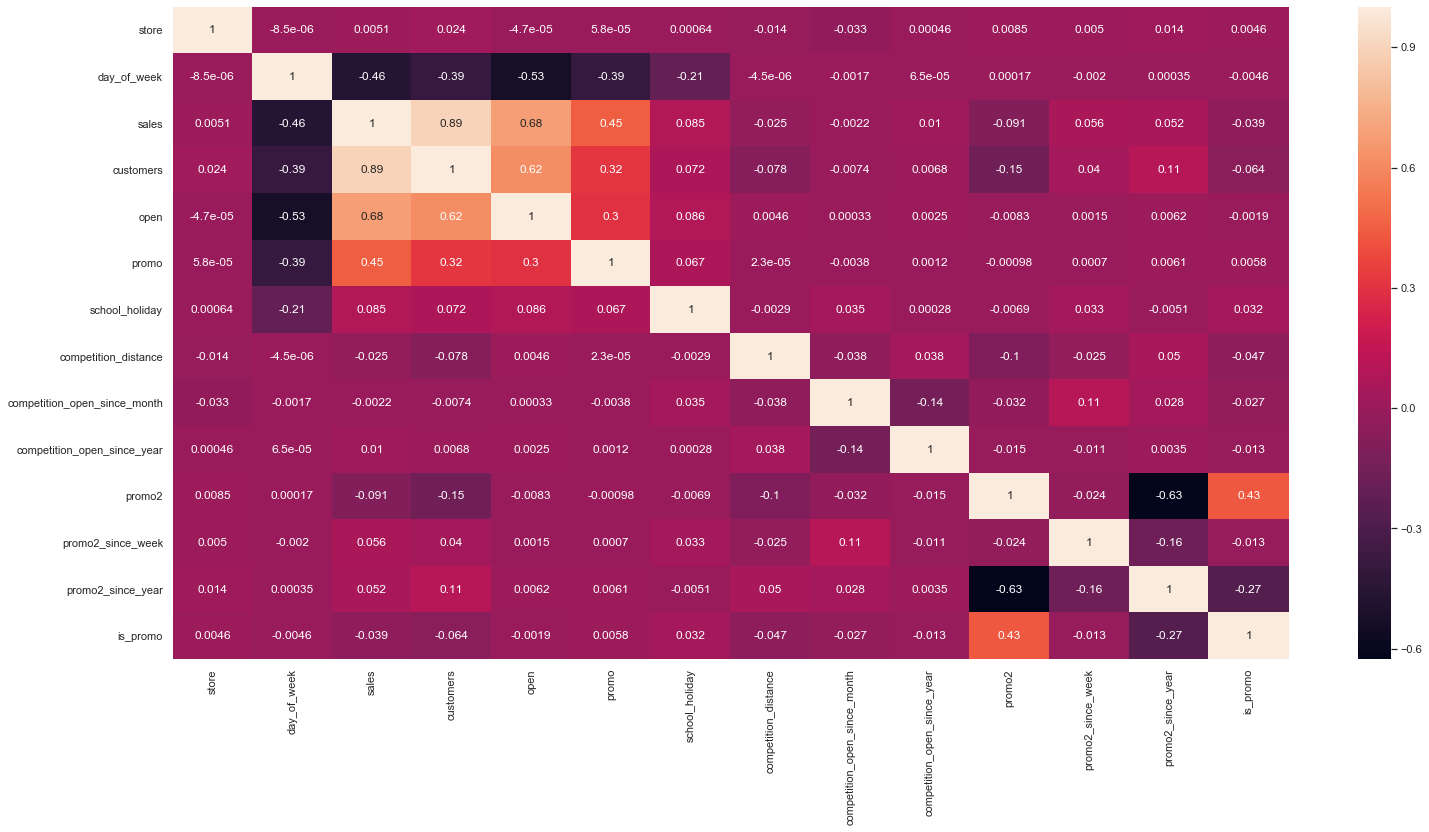

In [55]:
#Preto + correlacao negativa (bom)
#Branco + correlacao positiva (nao tao bom)
#Matriz simetrica - Se pegar qualquer lado da diagonal vai ser igual os valores. OBS: 1 e o meio.
#Valor = 1 e que as colunas sao iguais

correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True);

### 4.3.2 Categorical Attributes

In [63]:

def cramer_v (x,y):
    # Tabela de contigencia
    # Procura quantas vezes uma coluna aparece na outra
    cm = pd.crosstab (x, y).as_matrix()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( ( chi2corr / n ) / (min(kcorr-1, rcorr-1 ) ) )    


In [60]:
from scipy                 import stats

In [61]:
chi2 = ss.chi2_contigency( cm )

NameError: name 'ss' is not defined

In [62]:
v = np.sqrt( chi2/n ) / ( min( k-1, r-1 ) )

NameError: name 'chi2' is not defined

In [64]:


#Cramer V
# 0 to 1
# Proximo de 0 menor correlacao
# Proximo de 1 maior correlacao

#only categorical data
a = df4.select_dtypes( include='object' )


#Example
#state_holiday = christmas
#store_type = a
#Tem 4 colunas

a[(a['state_holiday'] == 'christmas') & (a['store_type'] == 'a') ]

#Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )


a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

#Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] })

d = d.set_index(d.columns)

sns.heatmap( d, annot=True );

<ipython-input-63-36fb8956bc73>:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cm = pd.crosstab (x, y).as_matrix()


NameError: name 'ss' is not defined

# 5.0. PASSO 05 -  DATA PREPARATION


In [66]:
df5 = df4.copy()
#df5['competition_time_month'] = df5['competition_time_month'].astype('int64')
#df5['promo_time_week'] = df5['promo_time_week'].astype('int64')


## 5.1 Rescaling

In [67]:
#Decide if we go to use MaxMin Rescaling or RobustScale
#IMPORTANT: For choose the method we need to know if the column has the OUTLIER. 

a = df5.select_dtypes( include=['int64', 'float64'] )

#RobustScale when have OUTLIER

rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

#competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

#year
df5['year'] = mms.fit_transform( df5[['year']].values )

#promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )


In [ ]:
#competition_distance
#year
#competition_time_month
#promo_time_week

#sns.boxplot (df5['competition_distance'])

#sns.boxplot (df5['competition_time_month'])

#sns.boxplot (df5['promo_time_week'])



## 5.2 Transformacao

### 5.2.1 Encoding

#### ONE HOT Enconding

**Cria uma coluna para cada iten da coluna categorica, colocando o numero 1 quando o nome e o item da coluna.**

exemplo: Item HOT - Coluna HOT - Numero 1 e o restante 0

dica: Bom para usar em estados. Feriados por example.

#### LABEL Enconding

**Cria uma coluna com o numero de cada iten da coluna categorica, colocando numero sequencial de acordo com o range dos itens em uma nova coluna.**

exemplo: HOT(1), COLD(2), VERY HOT(3), WARM(4) - Temp_label  = 1, 2, 3 ,4

dica: Variaveis onde tem apenas nomes.

#### ORDINAL Enconding

**Cria uma coluna com o numero de cada iten da coluna categorica, colocando numero sequencial de acordo com o range dos itens em uma nova coluna MAS TEM UMA ORDEM (maior para menor / mais fraco pro mais forte).**

exemplo: HOT(3), COLD(1), VERY HOT(4), WARM(2) - ORDINAL_label  = 4,3,2,1

dica: Variaveis onde tem apenas nomes.

#### TARGET Enconding

**Cria a MEDIA de VENDAS de cada item da coluna categorica.**

exemplo: HOT 20 mil , COLD 30 mil , VERY HOT 40 mil , WARM 60 mil - TARGET_enconding  = 0.5 , 0.7, 0.8, 0.9

dica: Com muitos itens 100, 200 itens diferentes.

#### FREQUENCY Enconding

**CONTA o numero de cada item vendido na coluna categorica e depois DIVIDE pela numero de vendas**

exemplo: HOT 20  , COLD 30 , VERY HOT 40 , WARM 60  - FREQUENCY_enconding  = 0.5 , 0.7, 0.8, 0.9

dica: Com muitos itens 100, 200 itens diferentes. Marca de carros.

#### EMBEDDING Enconding

**Sao camadas que tentam o relacionamento. Tentando manter a proximidade ddas palavras dentro de um contexto**

dica: Previsao de demandas

In [68]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_of_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week',
       'competition_distance_binned'],
      dtype='object')

In [69]:
#state_holiday (ONE HOT Enconding)
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

#store_type (LABEL Enconding)
le = LabelEncoder()
df5['store_type'] =  le.fit_transform(df5['store_type'])

#assortment (ORDINAL Enconding)
assortment_dict = {'basic' : 1, 'extra' : 2, 'extended' : 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.2.2 Response Variable Transformation

In [70]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.2.3 Nature Transformation

In [71]:
#day of week
df5['day_of_week_sen'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7 ) ) )

#month
df5['month_sen'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12 ) ) )

#day
df5['day_sen'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30 ) ) )



# 6.0. PASSO 06 - FEAUTURE SELECTION

"A explicacao mais simpes sobre um fenomeno observado, deveria prevalecer sobre explicacoes mais complexas." - (Occam's Razor / A navalha de Occam's)

**exemplo: Se voce tem 2 modelos, escolha o mais simples e que generalize mais, descreve a maior quantidade do modelo.**


Variaveis Colineares

**explicam a mesma parte do fenomemo**


### 6.1 Filter Methods (selecao Univariada)

**Classificar se uma variavel/feauter e relevante ou nao. Quais variaveis explicam mais e tem maior impacto no fenomemo**

**Verificar  a revelancia com o COEFICIENTE DE CORRELACAO proximo de 1 REVELANTE e proximo 0 MENOS REVELANTE**

Vantagens: **Metodo simples, Metodos Rapido e Facil entendmento**

Desvantagem: **Nao considera a influencia entre variaveis**

### 6.2 Embedded Methods (Selecao por Importancia)

**Uma method serve tanto para selecionar variaveis importante mas tambem e um algoritmo**

Exemplos **Random Forest, Lasso Regression, Ridge Regression**

#### 6.2.1 Random Forest (Gini Impurity)

Faz uma arvore com as variaveis e divide uma feauter para criar varios grupos homogenos. Se a ramificacao conseguir separar mais os dados em novos grupos, mais importancia tem.

#### 6.2.2 Lasso & Ridge Regression

Treinar uma regressao com LAsso ou Ridge, vai plotar os pesos das feautures, e vai selecionar as feautures por maior peso ou peso mais negativos. E tentar evitar as  variaveis com pesos proximos de zero.

### 6.3 Wrapper Methods (Selecao por SubSet)

Steps:
    1 - Seleciona uma unica variavel/feature + resposta
    
    2 - Treina um modelo de ML
    
    3 - Calcula a Ferformance do Modelo
    
    4 - A performance aumentou?
        4.1 - Sim - Mantem a variavel/feature - Adiciona outra variavel e volta ao passo 2
        4.2 - Nao - Remove a variavel/feature - Adiciona outra variavel e volta ao passo 2
   
   Final
   
   Tem um novo Subset/Dataset com as variaveis mais relevantes

**BORUTA** 

1 - Seleciona 2 variaveis

2 - Cria as Shadows Features

3 - Faz um Random Forest ou outra ML

4 - Ve a importancia das features/variaveis (Seleciona a Shadow Featuer mais proxima de 1)

5 - Compara os valores da Original Features com a Shadow Featuer maior.

    5.1 - Se a Original featuer for MAIOR que a Shadow Featuer = 1
    5.2 - Se a Original featuer for MENOR que a Shadow Featuer = 0
    
6 - Cria uma tablea SUCESS COUNTS com os resultados 0 e 1

7 - Acha o valor de p-value para validar o passo 6.

8 - Comparar os valores de p-value
    Se p-value for MENOR - REJECTED a featuer/variavel
    Se p-value for MAIOR - CONFIRM a featuer/variavel
    
9 - Resta apenas as featuer/variavel que foram CONFIRMADAS.

In [72]:
df6 = df5.copy()

In [73]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_of_week,competition_since,competition_time_month,promo_since,promo_time_week,competition_distance_binned,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regulary_day,day_of_week_sen,day_of_week_cos,month_sen,month_cos,day_sen,day_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,"(0, 1000]",0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,"(0, 1000]",0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,"(0, 1000]",0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,"(0, 1000]",0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,"(0, 1000]",0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148


## 6.1. Split dataframe into training and test dataset

In [74]:
cols_drop = ['day_of_week', 'day', 'month', 'promo_since', 'competition_since', 'year_of_week' ]
df6 = df6.drop(cols_drop, axis=1 )

In [75]:
#take the last 6 weeks
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta(days=6*7)
#df6[['store', 'date']].groupby( 'store' ).max().reset_index()

Timestamp('2015-06-19 00:00:00')

In [76]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#training dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']



print( 'Training min date: {}'.format( X_train['date'].min() ) )
print( 'Training max date: {}'.format( X_train['date'].max() ) )


print( '\nTest min date: {}'.format( X_test['date'].min() ) )
print( 'Test max date: {}'.format( X_test['date'].max() ) )


Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [77]:
#define training and test dataset for boruta
X_train_n = X_train.drop( ['date','sales'] , axis=1 ).values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)




In [ ]:

#define boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

In [80]:
cols_selected = boruta.support_.tolist()

# best feautures 
X_train_fs = X_train.drop( ['date','sales'] , axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()


#not selected boruta
cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))


NameError: name 'boruta' is not defined

In [79]:
cols_selected_boruta

NameError: name 'cols_selected_boruta' is not defined

In [81]:
cols_selected_boruta = [
    'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sen',
     'day_of_week_cos',
     'month_cos',
     'month_sen',
     'day_sen',
     'day_cos']


#columns to add

feat_to_add = ['date', 'sales']

#final features 
cols_select_boruta_full = cols_selected_boruta.copy()
cols_select_boruta_full.extend(feat_to_add)

In [108]:
cols_select_boruta_full = cols_selected_boruta.copy()
cols_select_boruta_full.extend(feat_to_add)

In [82]:
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,week_of_year,competition_time_month,promo_time_week,competition_distance_binned,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regulary_day,day_of_week_sen,day_of_week_cos,month_sen,month_cos,day_sen,day_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,31,0.918919,0.287016,"(0, 1000]",0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,31,1.054054,0.922551,"(0, 1000]",0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,31,1.202703,0.801822,"(0, 1000]",0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,31,0.743243,0.287016,"(0, 1000]",0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,31,-0.162162,0.287016,"(0, 1000]",0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148


# 7.0. PASSO 07 - MACHINE LEARNNING MODELLING

In [83]:
df7 = df6.copy()

In [84]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

In [85]:
x_training = X_train[cols_select_boruta_full]

## 7.1. Average Model

In [86]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction

aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={ 'sales':'predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

#performance

baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )

baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [87]:
#model
lr = LinearRegression().fit( x_train, y_train )

#prediction
yhat_lr = lr.predict( x_test )

#performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.255048,0.292406,2674.402343


### 7.2.1. Linear Regression Model - Cross Validation

In [88]:
lr_result_cv = cross_validation( x_training, 5, 'Linead Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linead Regression,2080.51 +/- 292.95,0.3 +/- 0.02,2950.33 +/- 464.0


## 7.3. Linear Regression Regularized Model - LASSO


In [89]:
#model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

#prediction
yhat_lrr = lrr.predict( x_test )

#performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation


In [90]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.2 +/- 341.42,0.29 +/- 0.01,3057.83 +/- 503.68


## 7.4. Random Forest Regressor


In [91]:
#model
rf =  RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

#prediction
yhat_rf = rf.predict( x_test )

#performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,704.093999,0.10482,1035.16328


### 7.4.1 Randon Forest Regresso - Cross Validation


In [92]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest', rf, verbose=False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,847.45 +/- 230.98,0.12 +/- 0.02,1268.31 +/- 336.21


## 7.5. XGBoost Regressor


In [96]:
#model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.07,
                              colsamlpe_bytree=0.9 ).fit( x_train, y_train )

#prediction
yhat_xgb = model_xgb.predict( x_test )

#performance
xgb_result = ml_error( 'XGBRegressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,890.736578,0.13214,1293.204433


### 7.5.1 XGBoost Regressor - Cross Validation


In [97]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold number: 5


c:\users\f0ints\repos\dsemproducao\dsemproducaoenv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\f0ints\repos\dsemproducao\dsemproducaoenv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold number: 4


c:\users\f0ints\repos\dsemproducao\dsemproducaoenv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\f0ints\repos\dsemproducao\dsemproducaoenv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold number: 3


c:\users\f0ints\repos\dsemproducao\dsemproducaoenv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\f0ints\repos\dsemproducao\dsemproducaoenv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold number: 2


c:\users\f0ints\repos\dsemproducao\dsemproducaoenv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\f0ints\repos\dsemproducao\dsemproducaoenv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold number: 1


c:\users\f0ints\repos\dsemproducao\dsemproducaoenv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\f0ints\repos\dsemproducao\dsemproducaoenv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1064.17 +/- 171.72,0.15 +/- 0.01,1532.62 +/- 237.68


## 7.6. Compare Model's Performance


### 7.6.1 Single Performance

In [98]:
modeling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modeling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,704.093999,0.104820,1035.163280
0,XGBRegressor,890.736578,0.132140,1293.204433
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1868.255048,0.292406,2674.402343
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performance - Cross Validation

In [99]:
modeling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modeling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linead Regression,2080.51 +/- 292.95,0.3 +/- 0.02,2950.33 +/- 464.0
0,Lasso,2116.2 +/- 341.42,0.29 +/- 0.01,3057.83 +/- 503.68
0,Random Forest,847.45 +/- 230.98,0.12 +/- 0.02,1268.31 +/- 336.21
0,XGBoost Regressor,1064.17 +/- 171.72,0.15 +/- 0.01,1532.62 +/- 237.68


# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [100]:
import random
import warnings

warnings.filterwarnings('ignore')

In [ ]:
param = {
    'n_estimator': [15, 17, 25, 30, 35],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colssample_bytree': [0.3, 0.8, 0.9],
    'min_child_weight': [3, 8, 15] }

MAX_EVAL = 2

In [101]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    #choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print(hp)
    #model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimator'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsamlpe_bytree=hp['colssample_bytree'],
                                  min_child_weight = hp['min_child_weight'])
    
    #performance
    result = cross_validation (x_training, 2, 'XGBRegressor', model_xgb, verbose=False)
    final_result = pd.concat( [final_result, result] )
    
final_result

NameError: name 'MAX_EVAL' is not defined

## 8.2. Final Model

In [113]:
param_tuned = {
    'n_estimator': 25,
    'eta': 0.01,
    'max_depth': 9,
    'subsample': 0.5,
    'colssample_bytree': 0.9,
    'min_child_weight': 15 }


In [114]:
#model
model_xgb_tuned = xgb.XGBRegressor(   objective='reg:squarederror',
                                      n_estimators=param_tuned['n_estimator'],
                                      eta=param_tuned['eta'],
                                      max_depth=param_tuned['max_depth'],
                                      subsample=param_tuned['subsample'],
                                      colsamlpe_bytree=param_tuned['colssample_bytree'],
                                      min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

#prediticon
yhat_xgb_tuned = model_xgb_tuned.predict ( x_test )

#performance
result_xgb_tuned = ml_error ('XGBRegressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
result_xgb_tuned



,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,3383.7074,0.434781,4192.744735


In [115]:
result_xgb_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,3383.7074,0.434781,4192.744735


In [116]:
import pickle

In [118]:
pickle.dump( result_xgb_tuned, open( 'C:\Users\f0ints\repos\DsEmProducao\model\model_rossmann.pkl', 'wb' ) )

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-118-df507360ff94>, line 1)

# 9.0. PASSO 09 - TRANSLATING ERROR

## 9.1 MAE - MEAN ABSOLUTE ERROR

**1 dividor por N (numero de predicoes) + SOMA do MODULO de Y (valor REAL - valor do dado/tabela/dataset ) - YHAT (valor PREDITO - valor do modelo)**

In [ ]:
Image( '../img/MAE.png' )

## 9.2 MAPE - MEAN ABSOLUTE PERCENTAGE ERROR

In [ ]:
Image( '../img/MAPE.png' )

O valor do MAE em porcentagem.

**Divide o valor do MAE pela media do Y_TEST pra achar o MAPE**

## 9.3 RMSE - ROOT MEAN SQUARE ERROR

In [ ]:
Image( '../img/RMSE.png' )

## 9.4 MPE - MEAN PERCENTAGE ERROR

In [ ]:
Image( '../img/MPE.png' )

## 9.5 RESUME METRICS

In [ ]:
Image( '../img/RESUME_METRICS.png' )

# 10.0. PASSO 10 - TRANSLATE AND INTERPRETATION OF ERRO

In [133]:
df9 = X_test[ cols_select_boruta_full ]

#rescale 
df9['sales'] = np.expm1( df9['sales'] )

df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 10.1. Business Performance

In [142]:
#sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

#MAE MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

#Merge

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )


#Scenarios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAPE']

#order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [147]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
816,817,168665.609375,152364.463610,168666.386712,16301.145765,0.777337
841,842,168401.906250,152583.120078,168402.678060,15818.786172,0.771810
697,698,142308.218750,129348.711076,142308.988493,12959.507674,0.769743
261,262,221084.359375,205034.321221,221085.113961,16050.038154,0.754586
512,513,164514.343750,151928.271973,164515.079643,12586.071777,0.735893


In [144]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
357,358,133085.937500,126905.097815,133086.568091,6180.839685,0.630591
977,978,143993.734375,140626.186576,143994.184184,3367.547799,0.449809
16,17,130519.046875,128037.686042,130519.422179,2481.360833,0.375304
711,712,119109.726562,116262.502903,119110.192030,2847.223659,0.465467


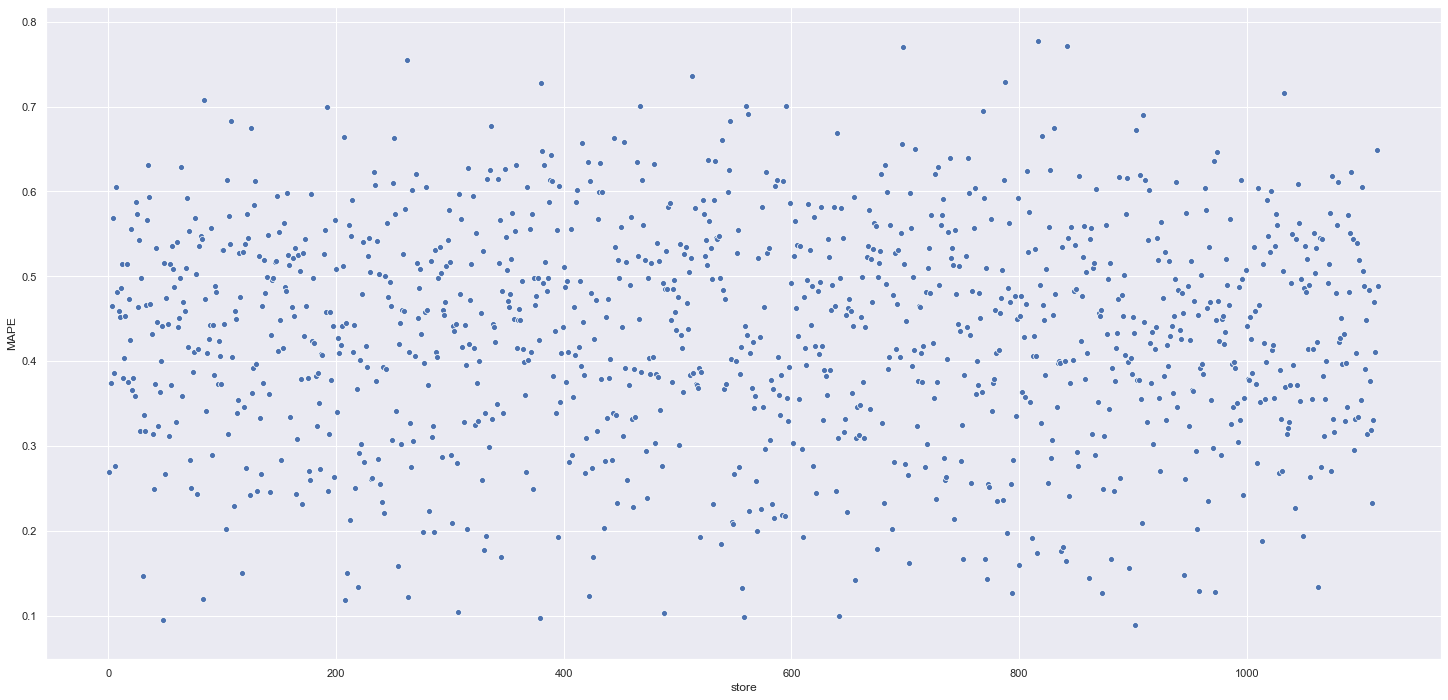

In [148]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 10.2. Total Performance

In [154]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename( columns={ 'index':'Scenario', 0:'Values'  })
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$150,273,010.41"
1,worst_scenario,"R$146,505,716.96"
2,best_scenario,"R$150,273,494.82"


## 10.3. Machine Learning Performance

In [155]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

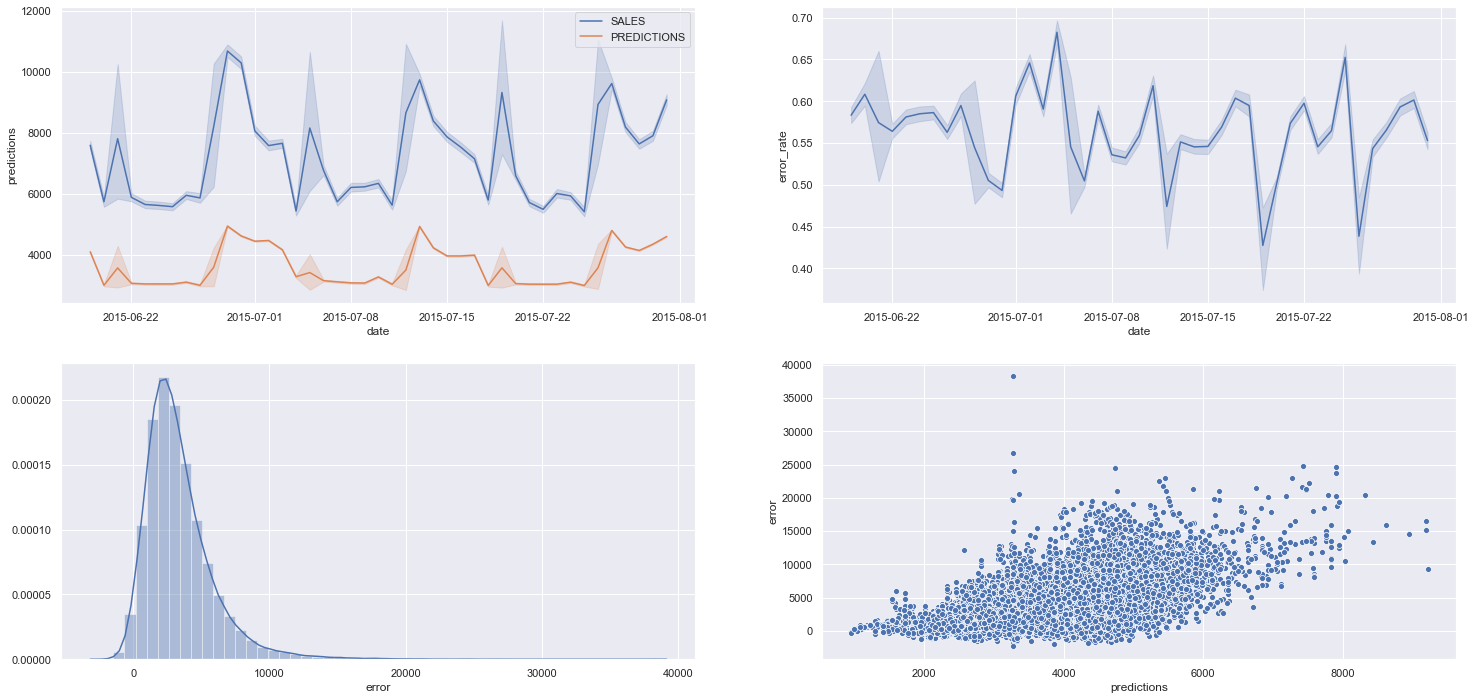

In [159]:
plt.subplot( 2, 2, 1)
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot( 2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=df9)

plt.subplot( 2, 2, 3)
sns.distplot( df9['error'])


plt.subplot( 2, 2, 4)
sns.scatterplot( df9['predictions'], df9['error'])

